# Fuck VAE

<img src="assets/vae.png"  width="600" />

In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '2'
import torch
torch.backends.cudnn.enabled = False
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
from torchvision import datasets, transforms
import torchvision.utils
from PIL import Image
from torchvision.utils import make_grid
from torch.utils.data.sampler import SubsetRandomSampler

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [2]:
class Encoder(nn.Module):
    def __init__(self, capacity, latent_dims, img_size):
        super(Encoder, self).__init__()
        self.capacity = capacity
        self.img_size = img_size
        self.latent_dims = latent_dims
        
        self.net = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=self.capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True),
            nn.Conv2d(in_channels=self.capacity, out_channels=self.capacity*2, kernel_size=4, stride=2, padding=1),
            nn.ReLU(inplace=True)
        )
        self.fc_mu = nn.Linear(in_features=int(self.capacity * 2 * self.img_size * self.img_size / 16), out_features=self.latent_dims)
        self.fc_logvar = nn.Linear(in_features=int(self.capacity * 2 * self.img_size * self.img_size / 16), out_features=self.latent_dims)
            
    def forward(self, x):
        x = self.net(x)
        x = x.view(x.size(0), -1)
        x_mu = self.fc_mu(x)
        x_logvar = self.fc_logvar(x)
        return x_mu, x_logvar

In [3]:
class Decoder(nn.Module):
    def __init__(self, capacity, latent_dims, img_size):
        super(Decoder, self).__init__()
        self.capacity = capacity
        self.img_size = img_size
        self.latent_dims = latent_dims
        self.fc = nn.Linear(in_features=self.latent_dims, out_features=int(self.capacity * 2 * self.img_size * self.img_size / 16))
        
        self.net = nn.Sequential(
            nn.ConvTranspose2d(in_channels=self.capacity*2, out_channels=self.capacity, kernel_size=4, stride=2, padding=1),
            nn.ReLU(True),
            nn.ConvTranspose2d(in_channels=self.capacity, out_channels=3, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
            
    def forward(self, x):
        x = self.fc(x)
        x = x.view(x.size(0), self.capacity * 2, int(self.img_size/4), int(self.img_size/4))
        x = self.net(x)
        return x

## Fuck VAE Loss

$$
\begin{aligned}
\mathcal{L} & =-\frac{1}{n} \sum_{i=1}^{n} \ell\left(p_{\theta}, q_{\phi}\right) \\
& =\frac{1}{n} \sum_{i=1}^{n} D_{K L}\left(q_{\phi}, p\right)-\frac{1}{n} \sum_{i=1}^{n} \mathbb{E}_{q_{\phi}}\left[\log p_{\theta}\left(x_{i} \mid z\right)\right] \\
& =\frac{1}{n} \sum_{i=1}^{n} D_{K L}\left(q_{\phi}, p\right)-\frac{1}{n m} \sum_{i=1}^{n} \sum_{j=1}^{m} \log p_{\theta}\left(x_{i} \mid z_{j}\right)
\end{aligned}
$$

In [4]:
class VAE(nn.Module):
    def __init__(self, capacity=64, latent_dims=32, img_size=128, kld_weight=1.0, device=device):
        super(VAE, self).__init__()
        self.encoder = Encoder(capacity, latent_dims, img_size).to(device)
        self.decoder = Decoder(capacity, latent_dims, img_size).to(device)
        self.img_size = img_size
        self.capacity = capacity
        self.latent_dims = latent_dims
        self.kld_weight = kld_weight
    
    def forward(self, x):
        latent_mu, latent_logvar = self.encoder(x)
        latent = self.latent_sample(latent_mu, latent_logvar)
        x_recon = self.decoder(latent)
        return x_recon, latent_mu, latent_logvar
    
    def latent_sample(self, mu, logvar):
        if self.training:
            # the reparameterization trick
            std = logvar.mul(0.5).exp_()
            eps = torch.empty_like(std).normal_()
            return eps.mul(std).add_(mu)
        else:
            return mu
    
    def vae_loss(self, x_recon, x, mu, logvar):
        # reconstruction loss
        recon_loss = F.binary_cross_entropy(x_recon.view(-1, self.img_size**2), x.view(-1, self.img_size**2), reduction='sum')
        kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
        return recon_loss + self.kld_weight * kld_loss

## Dataset: CelebA

In [5]:
def load_image_names(file_path):
    with open(file_path, 'r') as f:
        return [line.strip() for line in f]

root_dir = "data/CelebA/"
img_dir = root_dir + "Img/"
names = load_image_names("./" + root_dir + "/Eval/list_eval_partition.txt")
print(names[:10])

['000001.jpg 0', '000002.jpg 0', '000003.jpg 0', '000004.jpg 0', '000005.jpg 0', '000006.jpg 0', '000007.jpg 0', '000008.jpg 0', '000009.jpg 0', '000010.jpg 0']


In [6]:
# Stack image names with the corresponding partition offset
train_files, valid_files, test_files = [], [], []

for name in names:
    if name[-1] == "0":
        train_files.append(name[:-2])
    elif name[-1] == "1":
        valid_files.append(name[:-2])
    elif name[-1] == "2":
        test_files.append(name[:-2])

print(len(train_files))

162770


In [7]:
# Build a custom dataset
class CustomDataset(datasets.ImageFolder):
    def __init__(self, root, file_list, transform=None):
        super(CustomDataset, self).__init__(root, transform)
        self.file_list = set(file_list)
        self.samples = [s for s in self.samples if os.path.basename(s[0]) in self.file_list]
        self.targets = [s[1] for s in self.samples]

    def __getitem__(self, index):
        path, target = self.samples[index]
        sample = self.loader(path)
        if self.transform is not None:
            sample = self.transform(sample)
        return sample, target

In [8]:
img_size = 128
batch_size = 32
transform_train = transforms.Compose([transforms.RandomRotation(5),
                                      transforms.RandomHorizontalFlip(p=0.5),
                                      transforms.Resize(img_size),
                                      transforms.CenterCrop(img_size),
                                      transforms.ToTensor()])

transform_non_train = transforms.Compose([transforms.Resize(img_size),
                                          transforms.CenterCrop(img_size),
                                          transforms.ToTensor()])

dataset_train = CustomDataset(root=img_dir, file_list=train_files, transform=transform_train)
dataset_valid = CustomDataset(root=img_dir, file_list=valid_files, transform=transform_non_train)
dataset_test = CustomDataset(root=img_dir, file_list=test_files, transform=transform_non_train)

def random_load_images(dataset, n):
    
    # Create dataloader using a subset of the dataset
    indices = np.random.permutation(n)
    sampler = SubsetRandomSampler(indices)
    return torch.utils.data.DataLoader(dataset, batch_size, sampler=sampler)

dataloader_train = random_load_images(dataset_train, 10000)
dataloader_valid = random_load_images(dataset_valid, 1250)
dataloader_test = random_load_images(dataset_test, 1250)

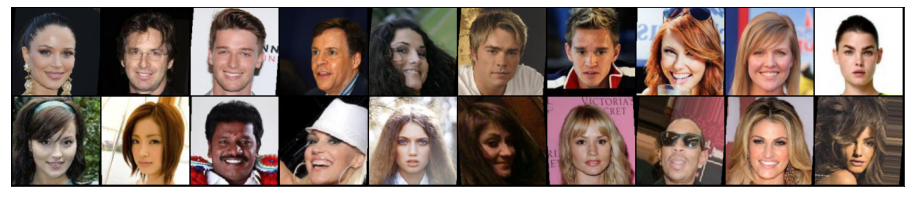

In [9]:
import matplotlib.pyplot as plt
images, _ = next(iter(dataloader_train))
fig, ax = plt.subplots(figsize=(16, 10))
ax.set_xticks([])
ax.set_yticks([])
ax.imshow(make_grid(images[:20], 10).permute(1, 2, 0));

## Train

In [10]:
vae = VAE().to(device)
optimizer = torch.optim.Adam(params=vae.parameters(), lr=1e-3, weight_decay=1e-5)

valid_loss_min = np.Inf 

n_epochs = 10
train_loss_list = []
valid_loss_list = []
for epoch in range(1, n_epochs+1):
    # initialize variables to monitor training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    # Train the VAE model
    vae.train()
    for batch_idx, (batch, _) in enumerate(dataloader_train):
        batch = batch.to(device)

        # vae reconstruction
        batch_recon, latent_mu, latent_logvar = vae(batch)
        
        # reconstruction error
        loss = vae.vae_loss(batch_recon, batch, latent_mu, latent_logvar)
        
        # backpropagation
        optimizer.zero_grad()
        loss.backward()
        
        # gradient step
        optimizer.step()
        
        train_loss += (loss.data - train_loss)/(batch_idx + 1)
        
    # Validate the VAE model
    vae.eval()
    for batch_idx, (batch, _) in enumerate(dataloader_valid):
        batch = batch.to(device)

        # vae reconstruction
        batch_recon, latent_mu, latent_logvar = vae(batch)
        
        # reconstruction error
        loss = vae.vae_loss(batch_recon, batch, latent_mu, latent_logvar)
        
        valid_loss += (loss.data - valid_loss)/(batch_idx + 1)
    
    train_loss_list.append(train_loss)
    valid_loss_list.append(valid_loss)

    # print training/validation statistics
    print("Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}".format(
        epoch, 
        train_loss,
        valid_loss
        ))
    
    if valid_loss <= valid_loss_min:
        print("Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...".format(
            valid_loss_min,
            valid_loss))
        torch.save(vae.state_dict(), "vae.pt")
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 895948.062500 	Validation Loss: 838484.562500
Validation loss decreased (inf --> 838484.562500).  Saving model ...
Epoch: 2 	Training Loss: 830152.375000 	Validation Loss: 816903.062500
Validation loss decreased (838484.562500 --> 816903.062500).  Saving model ...
Epoch: 3 	Training Loss: 819566.000000 	Validation Loss: 809925.875000
Validation loss decreased (816903.062500 --> 809925.875000).  Saving model ...
Epoch: 4 	Training Loss: 816518.125000 	Validation Loss: 807179.000000
Validation loss decreased (809925.875000 --> 807179.000000).  Saving model ...
Epoch: 5 	Training Loss: 815389.250000 	Validation Loss: 806065.687500
Validation loss decreased (807179.000000 --> 806065.687500).  Saving model ...
Epoch: 6 	Training Loss: 814299.687500 	Validation Loss: 807614.375000
Epoch: 7 	Training Loss: 813477.375000 	Validation Loss: 804803.062500
Validation loss decreased (806065.687500 --> 804803.062500).  Saving model ...
Epoch: 8 	Training Loss: 812932.875000 

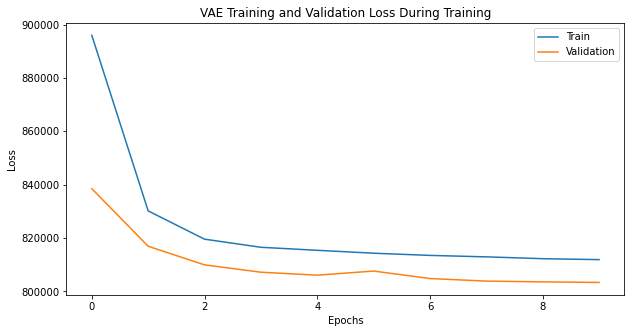

In [11]:
# Converting loss tensors to lists
for i in range(len(train_loss_list)):
    train_loss_list[i] = train_loss_list[i].to('cpu').numpy().tolist()
    valid_loss_list[i] = valid_loss_list[i].to('cpu').numpy().tolist()
plt.figure(figsize=(10, 5))
plt.title("VAE Training and Validation Loss During Training")
plt.plot(train_loss_list, label="Train")
plt.plot(valid_loss_list, label="Validation")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

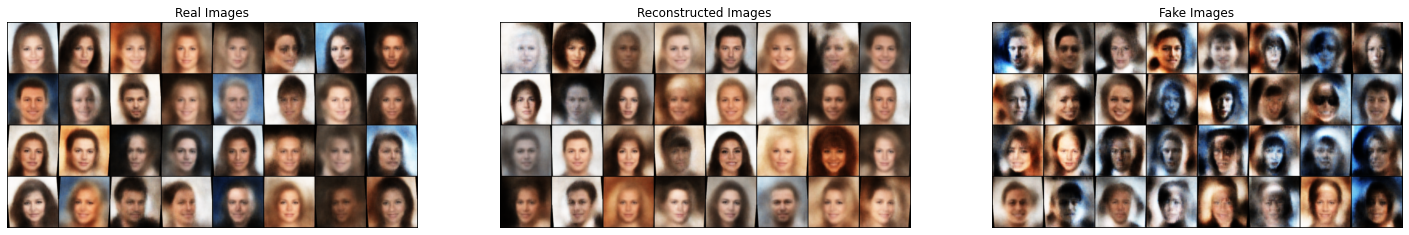

In [13]:
# Disable gradient calculation
torch.set_grad_enabled(False)

# Create a figure with three subplots
fig, axs = plt.subplots(1, 3, figsize=(25, 10))

# Real Images
axs[0].axis("off")
axs[0].set_title("Real Images")
real_images = make_grid(images.to(device)[:32], padding=2, normalize=True).cpu()
axs[0].imshow(np.transpose(real_images, (1, 2, 0)))

torch.set_grad_enabled(False)  # Manually disable gradient computation

images, _ = next(iter(dataloader_train))
images = images.to(device)
images, _, _ = vae(images)
images = images.cpu()

# Reconstructed Images
axs[1].axis("off")
axs[1].set_title("Reconstructed Images")
reconstructed_images = images
reconstructed_images_grid = make_grid(reconstructed_images[:32], padding=2, normalize=True)
axs[1].imshow(np.transpose(reconstructed_images_grid, (1, 2, 0)))

# Generate Fake Images
torch.set_grad_enabled(False)  # Manually disable gradient computation

latent = torch.randn(128, 32, device=device)
img_recon = vae.decoder(latent)
img_recon = img_recon.cpu()

axs[2].axis("off")
axs[2].set_title("Fake Images")
fake_images_grid = make_grid(img_recon.data[:32], padding=2, normalize=True)
axs[2].imshow(np.transpose(fake_images_grid.numpy(), (1, 2, 0)))